In [1]:
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict, Any, Union
from openpyxl import load_workbook


In [2]:
PATH_THEORY = "../../Data/Theory/MasterNuclei.xlsx"


In [3]:
# Matplotlib settings all LATEX
import matplotlib
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"], "size":18})
rc("text", usetex=True)

In [4]:
MPLHEP = False
if MPLHEP:
    import mplhep as hep
    plt.style.use(hep.style.CMS)

In [5]:
sys.path.append("../../nuclearpy_models")
from models.BE import dz_be, semf_be
from models.BE import dz_be, semf_be, sr_be
from utils.metrics import RegressionMetrics

In [6]:
exp_df = pd.read_csv('../../Data/Experimental/AME2020.csv', delimiter=',').query("Z>15").drop_duplicates(subset=['Z', 'N']).query("Z<=50")
exp_df["A"] = exp_df["Z"] + exp_df["N"]
exp_df = exp_df.query("Z <= 50")

In [7]:
exp_df["semf_pred"] = exp_df.apply(lambda x: semf_be(x["Z"], x["N"]), axis=1)
exp_df["dz_pred"] = exp_df.apply(lambda x: dz_be(x["Z"], x["N"]), axis=1)
exp_df["sr_pred"] = (exp_df.apply(lambda x: sr_be(x["Z"], x["N"]), axis=1))
exp_df["sr_error"] = exp_df["sr_pred"] - exp_df["BE"]
exp_df["dz_error"] = exp_df["dz_pred"] - exp_df["BE"]


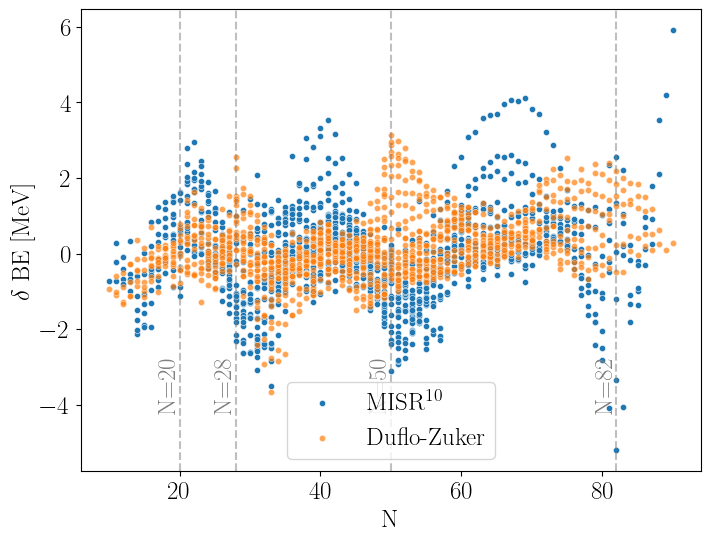

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(data=exp_df, x="N", y="sr_error", label=r"MISR$^{10}$", s=20)
sns.scatterplot(data=exp_df, x="N", y="dz_error", label="Duflo-Zuker", alpha=0.7, s=20)

# Labels for scientific notation
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.set(xlabel="N", ylabel=r"$\delta$ BE [MeV]")
# hlines on the magic numbers
magic_numbers = [20, 28, 50, 82]
for i in magic_numbers:
    ax.axvline(i, color="grey", linestyle="--", alpha=0.5)
    # Add vertical text to each line
    ax.text(i, -3.5, f"N={i}", rotation=90, verticalalignment="center", horizontalalignment="right", color="grey")
plt.savefig("sr_dz_error.pdf", bbox_inches="tight")

#### Loading test

In [9]:
PATH_THEORY = "../../Data/Theory/MasterNuclei.xlsx"
def get_sheets_name(filename):
    workbook = load_workbook(filename)
    return workbook.sheetnames


used_dfs = [
    "DD-ME2",
    # "SKMS",
    "HFB24",
    "NL3S",
    "UNEDF1",
]

th_datastes = get_sheets_name(PATH_THEORY)
th_datastes = [th_dataste for th_dataste in used_dfs if th_dataste != "AME2020"]

In [10]:
th_datastes

['DD-ME2', 'HFB24', 'NL3S', 'UNEDF1']

In [11]:
thdfs = {th_dataste: pd.read_excel(PATH_THEORY, sheet_name=th_dataste).query("Z >= 12 and N>=12").query("(N+Z)<250") for th_dataste in th_datastes}

In [12]:
def get_th_pred(Z, N, df_th):
    try:
        return df_th[(df_th["Z"] == Z) & (df_th["N"] == N)]["BE"].values[0]
    except:
        return np.nan

def patient_semf(Z, N):
    try:
        return dz_be(Z, N)
    except Exception as e:
        return np.nan

all_th_dfs = {}
all_th_in_exp = {}
for df_name in used_dfs:
    foo = thdfs.get(df_name).copy()
    foo["th_pred"] = foo.apply(lambda x: get_th_pred(x["Z"], x["N"], thdfs[df_name]), axis=1)
    foo["dz_pred"] = foo.apply(lambda x: patient_semf(x["Z"], x["N"]), axis=1)
    foo["dz_diff"] = foo.apply(lambda x: x["dz_pred"] - x["th_pred"], axis=1)
    foo["sr"] = foo.apply(lambda x: sr_be(x["Z"], x["N"]), axis=1)
    all_th_dfs[df_name] = foo.dropna()
    foo = exp_df.copy()
    foo["th_pred"] = foo.apply(lambda x: get_th_pred(x["Z"], x["N"], thdfs[df_name]), axis=1)
    foo["dz_pred"] = foo.apply(lambda x: patient_semf(x["Z"], x["N"]), axis=1)
    foo["dz_diff"] = foo.apply(lambda x: x["dz_pred"] - x["th_pred"], axis=1)
    foo["sr"] = foo.apply(lambda x: sr_be(x["Z"], x["N"]), axis=1)
    all_th_in_exp[df_name] = foo.dropna()


# Regression Metrics

In [13]:
exp_df = exp_df.query("Z >= 12").query("Z<=50")

In [14]:
semf_metrics = RegressionMetrics(exp_df["BE"], exp_df["semf_pred"], "SEMF")()
dz_metrics = RegressionMetrics(exp_df["BE"], exp_df["dz_pred"], "DZ")()
dz_sr_metrics = RegressionMetrics(exp_df["BE"], exp_df["sr_pred"], "sr")()
results = pd.concat([semf_metrics, dz_metrics, dz_sr_metrics], axis=0)

for df_name in used_dfs:
   res = (RegressionMetrics(all_th_in_exp[df_name]["BE"], all_th_in_exp[df_name]["th_pred"], df_name)())
   results = pd.concat([results, res], axis=0)
all_th_dfs: Dict[str, pd.DataFrame]

results[["RMSE"]].sort_values(by="RMSE", inplace=False).rename(columns={"RMSE": "RMSE [MeV]"})

sr_rmse = results.reset_index().query("index == 'sr'")["RMSE"].values[0]
dz_rmse = results.reset_index().query("index == 'DZ'")["RMSE"].values[0]

In [15]:
results[["MAE", "RMSE"]]

,MAE,RMSE
SEMF,3.457480,4.842702
DZ,0.601646,0.825777
sr,0.924948,1.222309
DD-ME2,2.478863,2.825439
HFB24,0.543233,0.727646
NL3S,1.940749,2.427906
UNEDF1,1.745995,2.060744


In [16]:
def plot_isotope_be(
    df: pd.DataFrame,
    models: List[callable] = [dz_be, dz_be],
    model_names: List[str] = ["DZ", "SR"],
    fixed_z: int = 50,
    n_max = 120,
    ):

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    foo_df = df.query(f"Z=={fixed_z}")
    n_min = foo_df["N"].min()
    ns_in = foo_df["N"].values
    ns_out = np.arange(ns_in.max(), n_max)
    all_ns = np.concatenate([ns_in, ns_out])
    y = np.array([dz_be(fixed_z, n) for n in all_ns])
    ax.plot(foo_df["N"], foo_df["BE"]*0, label="Duflo Zuker", color="black", alpha=0.5)
    plt.errorbar(foo_df["N"], foo_df["BE"], yerr=foo_df["uBE"], fmt="o", label="Experiment", color="black")
    ax.hlines(0, n_min, n_max, color="black", linestyle="-")
    SEMF_error = foo_df["dz_pred"] - foo_df["BE"]
    sns.scatterplot(x="N", y=SEMF_error, data=foo_df, ax=ax, label=None, color="black")
    for i, (model, name) in enumerate(zip(models, model_names)):
        preds_in = np.array([model(fixed_z, n) for n in all_ns])
        errors = y - preds_in
        sns.scatterplot(x=all_ns, y=errors, ax=ax, color=f"C{i}", s=5)
        sns.lineplot(x=all_ns, y=errors, ax=ax, color=f"C{i}", linestyle=":", label=name)
    for j, df_name in enumerate(used_dfs):
        sns.scatterplot(x="N", y="dz_diff", data=all_th_dfs[df_name].query(f"Z=={fixed_z}"), ax=ax, s=10, color=f"C{j+2+i}")
        sns.lineplot(x="N", y="dz_diff", data=all_th_dfs[df_name].query(f"Z=={fixed_z}"), ax=ax, linestyle="--", label=df_name,  color=f"C{j+2+i}")

    ax.set(xlabel="N", ylabel=r"$\delta(BE)$ [MeV]", xlim=(n_min, n_max), ylim=(-10, 10))
    # put the legend in the left down corner
    ax.legend(fontsize=14)
    # Add annotations inside good looking boxes
    ax.annotate(f"Z={fixed_z}", xy=(0.5, 0.9), xycoords="axes fraction", fontsize=22)
    ax.legend(fontsize=14)
    plt.savefig(f"BE_{fixed_z}.pdf", bbox_inches="tight")

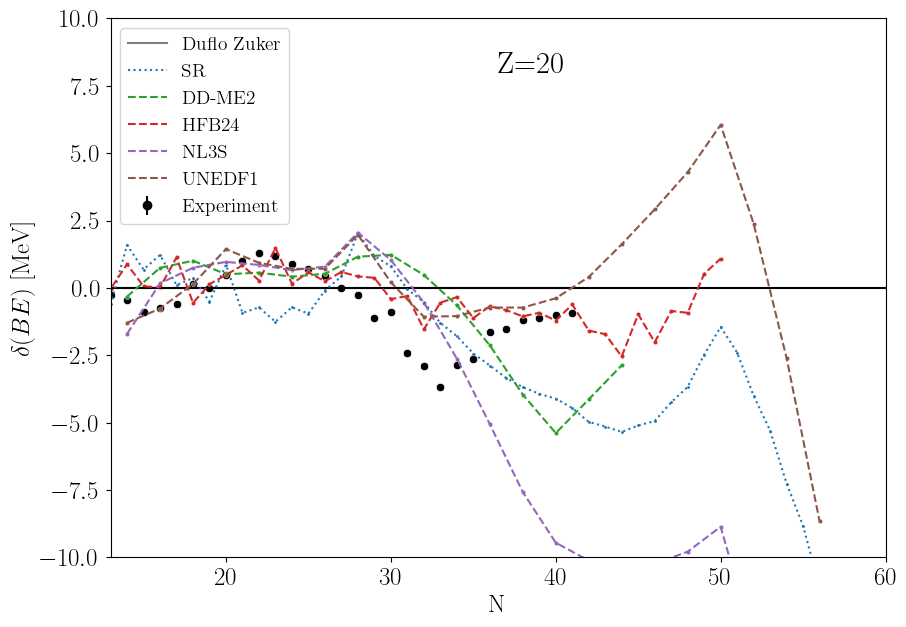

In [17]:
plot_isotope_be(exp_df, models=[sr_be],
                model_names = ["SR"],
                fixed_z=20, n_max=60)

# Unseen data

In [18]:
# full_exp_df = pd.read_excel("../../Data/Theory/MasterNuclei.xlsx", sheet_name="AME2020").query("Z>=12").query("Z<=50")
be_test = pd.read_csv("/Users/jose/Documents/Works/MIT/AI/PyMassModels/Data/Experimental/be_test.csv", delimiter=",").query("Z>=12").query("Z<=50")
be_test["is_test"] = [True] * len(be_test)
be_train = pd.read_csv("/Users/jose/Documents/Works/MIT/AI/PyMassModels/Data/Experimental/be_train.csv", delimiter=",").query("Z>=12").query("Z<=50")
be_train["is_test"] = [False] * len(be_train)
full_exp_df = pd.concat([be_test, be_train], axis=0)

In [19]:
%%capture
full_exp_df["sr_pred"] = full_exp_df.apply(lambda x: sr_be(x["Z"], x["N"]), axis=1)
full_exp_df["SEMF"] = full_exp_df.apply(lambda x: semf_be(x["Z"], x["N"]), axis=1)
full_exp_df["dz_pred"] = full_exp_df.apply(lambda x: dz_be(x["Z"], x["N"]), axis=1)

In [20]:
full_exp_df = full_exp_df.query("Z > 12 and Z <= 50")

# Smart ensemble of the models

In [91]:
from sklearn.linear_model import ARDRegression

# Create the linear regression model
model = ARDRegression()

# Train the model
model.fit(full_exp_df.query("is_test == False")[["sr_pred", "dz_pred", "N", "Z"]].values,
          full_exp_df.query("is_test == False")["BE"])

ARDRegression()

In [92]:
# def model_ensemble(Z, N):
#     return (sr_be(Z, N) + dz_be(Z, N)) / 2
def model_ensemble(Z, N):
    inpupt_sr = sr_be(Z, N)
    input_dz = dz_be(Z, N)
    return model.predict([[ inpupt_sr, input_dz, N, Z]])[0]

In [93]:
ensemble_pred = full_exp_df.apply(lambda x: model_ensemble(x["Z"], x["N"]), axis=1)
full_exp_df["ensemble_pred"] = ensemble_pred
full_exp_df["ensemble_error"] = full_exp_df["ensemble_pred"] - full_exp_df["BE"]

RMSE: 0.693, MAE: 0.509


<Axes: xlabel='N', ylabel='ensemble_error'>

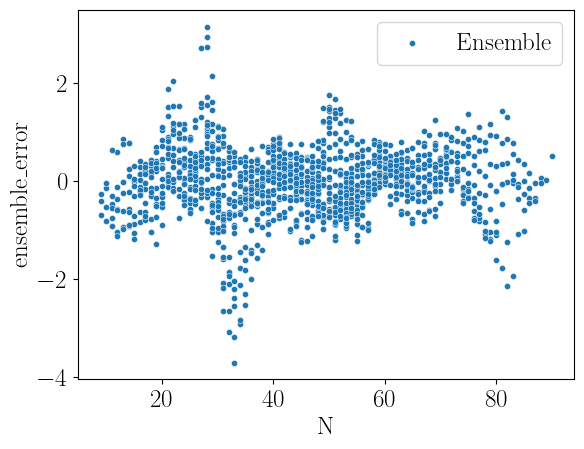

In [94]:
rmse, mae = np.sqrt(np.mean(full_exp_df["ensemble_error"]**2)), np.mean(np.abs(full_exp_df["ensemble_error"]))
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}")
sns.scatterplot(x="N", y="ensemble_error", data=full_exp_df, label="Ensemble", s=20)

# Neutron Separation energies

In [25]:
sn_df = full_exp_df.copy().query("Z>=20")

In [26]:
def predict_sn(Z, N, model):
    return model(Z, N+1) - model(Z, N)

def experimental_sn(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "sn_exp"] = df[(df["Z"] == row["Z"]) & (df["N"] == row["N"]+1)]["BE"].values[0] - row["BE"]
        except:
            df.at[i, "sn_exp"] = np.nan
    return df

def theory_sn(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z) & (th_df["N"] == N+1)]["BE"].values[0] - th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0]
    except Exception as e:
        # raise e
        return np.nan


In [27]:
sn_df["exp_sn"] = experimental_sn(sn_df)["sn_exp"]
sn_df["sr_sn"] = sn_df.apply(lambda x: predict_sn(x["Z"], x["N"], sr_be), axis=1)
sn_df["dz_sn"] = sn_df.apply(lambda x: predict_sn(x["Z"], x["N"], dz_be), axis=1)
# sn_df["theory_sn"] = sn_df.apply(lambda x: theory_sn(x["Z"], x["N"], full_exp_df), axis=1)
sn_df["ensemble_sn"] = sn_df.apply(lambda x: predict_sn(x["Z"], x["N"], model_ensemble), axis=1)

In [28]:
for th_name in used_dfs:
    sn_df[f"{th_name}_sn"] = sn_df.apply(lambda x: theory_sn(x["Z"], x["N"], thdfs[th_name]), axis=1)

In [29]:
def get_experimiental_unc_sn(Z, N, df):
    try:
        return df[(df["Z"] == Z) & (df["N"] == N+1)]["uBE"].values[0] + df[(df["Z"] == Z) & (df["N"] == N)]["uBE"].values[0]
    except:
        return np.nan

In [59]:
dz_rmse = np.sqrt(np.mean((sn_df["exp_sn"] - sn_df["dz_sn"])**2))
sr_rmse = np.sqrt(np.mean((sn_df["exp_sn"] - sn_df["sr_sn"])**2))
ensm_rmse = np.sqrt(np.mean((sn_df["exp_sn"] - sn_df["ensemble_sn"])**2))
undef_1_rmse = np.sqrt(np.mean((sn_df["exp_sn"] - sn_df["UNEDF1_sn"])**2))
print(f"SR RMSE: {sr_rmse}, DZ RMSE: {dz_rmse}, Ensemble RMSE: {ensm_rmse}, UNEDF1 RMSE: {undef_1_rmse}")

SR RMSE: 1.5737381503502696, DZ RMSE: 1.4779834420887634, Ensemble RMSE: 1.4780019571139156, UNEDF1 RMSE: 1.4131822925803854


In [121]:
def plot_sn_energy(fixed_z, n_min, n_max, annotation_text="", save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    foo_df = sn_df.query(f"Z=={fixed_z}")# and N>={n_min} and N<={n_max}")
    # predict for models

    pres = [predict_sn(fixed_z, n, model_ensemble) for n in range(n_min, n_max+1)]
    # predz = [predict_sn(fixed_z, n, dz_be) for n in range(n_min, n_max+1)]
    # experimental
    exp = []
    unc = []
    for n in range(n_min, n_max+1):
        try:
            exp.append(sn_df[(sn_df["Z"] == fixed_z) & (sn_df["N"] == n)]["exp_sn"].values[0])
            unc.append(get_experimiental_unc_sn(fixed_z, n, sn_df))
        except:
            exp.append(np.nan)
            unc.append(np.nan)
    plt.errorbar(range(n_min, n_max+1), exp, yerr=unc, fmt='.k', label="Experiment", color="black", capsize=5)
    # Color the area between the uncertainty
    ax.fill_between(range(n_min, n_max+1), np.array(exp)-np.array(unc), np.array(exp)+np.array(unc), color="black", alpha=0.1)
    # For uncertainty
    print(len(unc), len(foo_df["exp_sn"]))

    sns.lineplot(x="N", y="exp_sn", data=foo_df, color="black")
    # For sr
    sns.scatterplot(x=range(n_min, n_max+1), y=pres, label="Ensemble", color="red", s=200, marker="+")
    # For dz
    # sns.scatterplot(x=range(n_min, n_max+1), y=predz, label="Duflo Zucker", color="blue")
    # sns.scatterplot(x="N", y="dz_sn", data=foo_df, label="DZ", color="blue")
    sns.scatterplot(x="N", y="UNEDF1_sn", data=foo_df, label="UNEDF1", color="green")
    # Plot an horizontal line at 0
    ax.hlines(0, n_min, n_max, color="black", linestyle="--", alpha=0.5)
    # sns.scatterplot(x="N", y="ensemble_sn", data=foo_df, label="Ensemble", color="orange")
    ax.set(xlabel="N", ylabel=r"$S_n$ [MeV]")
    ax.set_xlim(n_min, n_max)
    ax.set_ylim(-5, 8)
    ax.legend(fontsize=22, loc="lower left")
    # Add an annotation for the $Z$ value and text
    if annotation_text:
        ax.annotate(annotation_text, xy=(0.5, 0.9), xycoords="axes fraction", fontsize=22)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")


/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_99753/700147467.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(range(n_min, n_max+1), exp, yerr=unc, fmt='.k', label="Experiment", color="black", capsize=5)


16 35


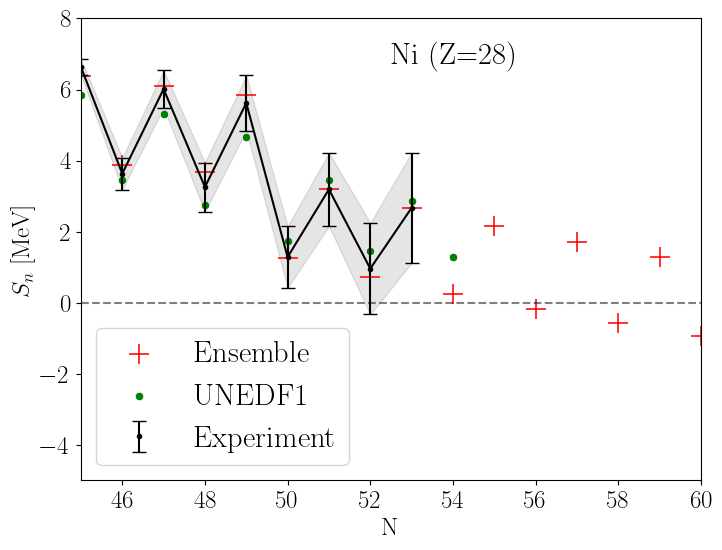

In [122]:
plot_sn_energy(28, 45, 60, "Ni (Z=28)", "sn_ni.pdf")

/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_99753/700147467.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(range(n_min, n_max+1), exp, yerr=unc, fmt='.k', label="Experiment", color="black", capsize=5)


27 29


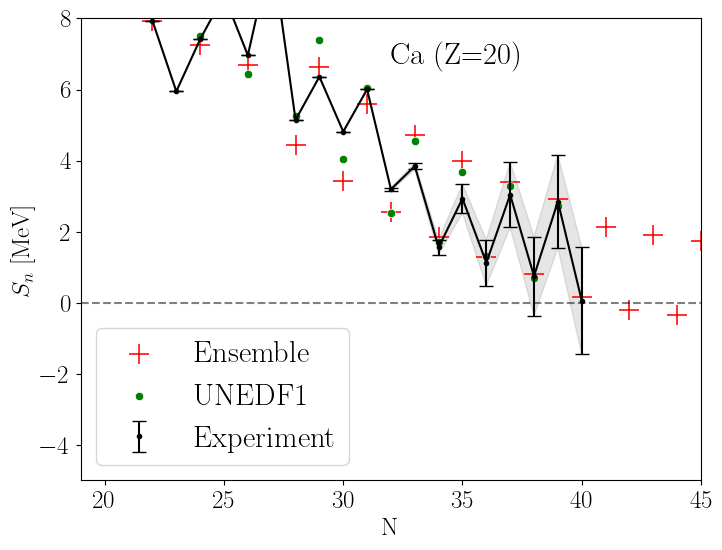

In [126]:
plot_sn_energy(20, 19, 45, "Ca (Z=20)")

In [127]:
plot_sn_energy(17, 17, 45, "Cl (Z=17)")

/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_99753/700147467.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(range(n_min, n_max+1), exp, yerr=unc, fmt='.k', label="Experiment", color="black", capsize=5)
/Users/jose/anaconda3/envs/envSr/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/jose/anaconda3/envs/envSr/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


29 0


In [79]:
# import pymc as pm
# import numpy as np

# # Simulated data for illustration (replace these with your actual data)
# model1_output = full_exp_df["sr_pred"].values
# model2_output = full_exp_df["dz_pred"].values
# N = full_exp_df["N"].values
# Z = full_exp_df["Z"].values
# y = full_exp_df["BE"].values

# # Prepare input for the neural network (NN)
# NZ = np.vstack([N, Z]).T

# with pm.Model() as model:
#     # Neural network architecture
#     weights_NZ = pm.Normal('weights_NZ', 0, 1, shape=(2, 1))
#     bias_NZ = pm.Normal('bias_NZ', 0, 1)

#     # NN_output = tt.nnet.sigmoid(tt.dot(NZ, weights_NZ) + bias_NZ) # DEPROCIATED
#     NN_output = pm.math.sigmoid(pm.math.dot(NZ, weights_NZ) + bias_NZ)

#     # Ensemble prediction
#     ensemble_pred = NN_output.flatten() * model1_output + (1 - NN_output.flatten()) * model2_output
#     # Likelihood (data likelihood)
#     y_obs = pm.Normal('y_obs', mu=ensemble_pred, sigma=1, observed=y)
#     # Inference
#     trace = pm.sample(1000)

# Proton Separation energies


In [33]:
sp_df = full_exp_df.copy().query("Z>=12")
def predict_sp(Z, N, model):
    return model(Z, N) - model(Z-1, N)

def experimental_sp(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "sp_exp"] = -df[(df["Z"] == row["Z"]-1) & (df["N"] == row["N"])]["BE"].values[0] + row["BE"]
        except:
            df.at[i, "sp_exp"] = np.nan
    return df

def theory_sp(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0] - th_df[(th_df["Z"] == Z-1) & (th_df["N"] == N)]["BE"].values[0]
    except:
        return np.nan


In [34]:
sp_df["exp_sp"] = experimental_sp(sp_df)["sp_exp"]
sp_df["sr_sp"] = sp_df.apply(lambda x: predict_sp(x["Z"], x["N"], sr_be), axis=1)
sp_df["dz_sp"] = sp_df.apply(lambda x: predict_sp(x["Z"], x["N"], dz_be), axis=1)
sn_df["ensemble_sp"] = sn_df.apply(lambda x: predict_sp(x["Z"], x["N"], model_ensemble), axis=1)

In [35]:
for th_name in used_dfs:
    sp_df[f"{th_name}_sp"] = sp_df.apply(lambda x: theory_sp(x["Z"], x["N"], thdfs[th_name]), axis=1)

In [36]:
sp_df

,BE,uBE,N,Z,eBE,x,A,ee,eo,oe,...,ensemble_pred,ensemble_error,sp_exp,exp_sp,sr_sp,dz_sp,DD-ME2_sp,HFB24_sp,NL3S_sp,UNEDF1_sp
2,652.080000,0.400000,39,41,1,4,80,0.0,0.0,0.0,...,650.976332,-1.103668,13.099378,13.099378,-0.964198,-1.36697,NaN,-1.791015,NaN,NaN
4,364.994243,0.005311,25,18,0,49,43,0.0,1.0,0.0,...,365.617594,0.623352,3.843921,3.843921,14.782538,15.00003,NaN,14.318985,NaN,16.220095
6,806.540000,0.294000,49,49,1,0,98,0.0,0.0,0.0,...,805.203824,-1.336176,0.440774,0.440774,0.658651,0.44003,NaN,0.488985,NaN,0.199809
8,486.964909,0.050002,28,30,0,4,58,1.0,0.0,0.0,...,487.699585,0.734677,2.278826,2.278826,2.586631,2.23403,NaN,2.558985,NaN,3.745401
9,595.386376,0.000782,38,30,0,64,68,1.0,0.0,0.0,...,595.436453,0.050077,9.976576,9.976576,10.886289,10.41203,NaN,10.208985,NaN,10.624771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2740,524.806152,0.000402,33,27,0,36,60,0.0,0.0,0.0,...,524.122211,-0.683941,8.274451,8.274451,8.746763,8.58103,NaN,7.568985,NaN,7.814219
2744,830.309805,0.035463,52,45,0,49,97,0.0,0.0,1.0,...,829.232198,-1.077607,3.806157,3.806157,3.561620,3.71103,NaN,3.428985,NaN,4.215495
2745,773.626424,0.370010,47,46,0,1,93,0.0,1.0,0.0,...,772.935419,-0.691005,3.271683,3.271683,3.832517,3.68203,NaN,3.868985,NaN,3.687260
2746,1103.261000,0.411000,88,49,1,1521,137,0.0,0.0,1.0,...,1103.963684,0.702684,NaN,NaN,15.899252,14.78103,NaN,15.708985,NaN,15.189168


In [37]:
def plot_sp_energy(fixed_n, z_min, z_max):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    foo_df = sp_df.query(f"N=={fixed_n} and Z>={z_min} and Z<={z_max}")
    # predict for models
    pres = [predict_sp(z, fixed_n, sr_be) for z in range(z_min, z_max+1)]
    predz = [predict_sp(z, fixed_n, dz_be) for z in range(z_min, z_max+1)]
    sns.scatterplot(x="Z", y="exp_sp", data=foo_df, label="AME2016", color="black", marker="x")
    sns.lineplot(x="Z", y="exp_sp", data=foo_df, color="black")
    # For sr
    sns.scatterplot(x=range(z_min, z_max+1), y=pres, label="SR", color="red")
    # For dz
    sns.scatterplot(x=range(z_min, z_max+1), y=predz, label="Dulfo-Zuker", color="blue")
    # sns.scatterplot(x="N", y="dz_sn", data=foo_df, label="DZ", color="blue")
    sns.scatterplot(x="Z", y="UNEDF1_sp", data=foo_df, label="UNEDF0", color="green")
    # sns.scatterplot(x="N", y="ensemble_sn", data=foo_df, label="Ensemble", color="orange")
    ax.set(xlabel="Z", ylabel=r"$S_p$ [MeV]", title=f"$N = {fixed_n}$, $Z = {z_min}-{z_max}$")
    ax.legend(fontsize=14)


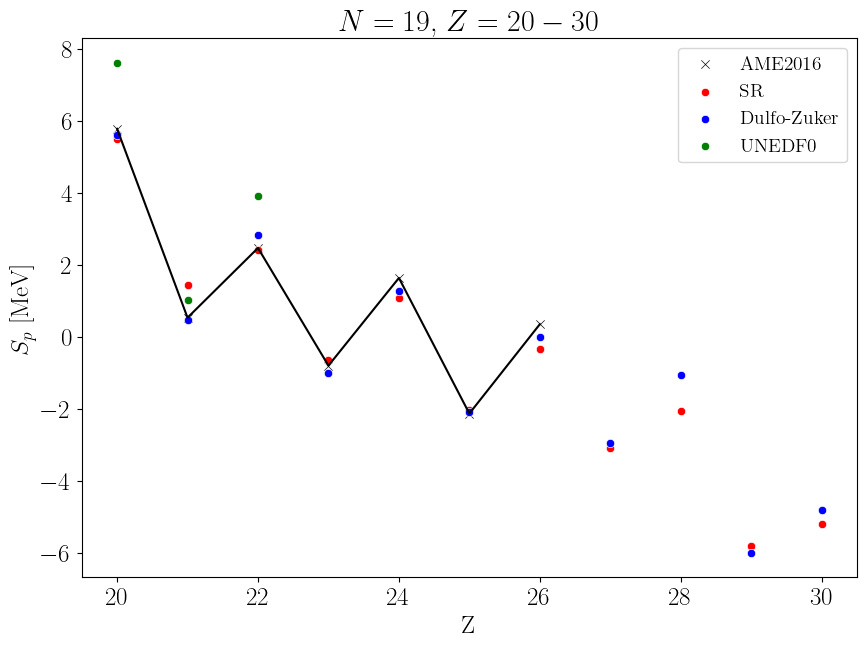

In [38]:
plot_sp_energy(19, 20, 30)

# Two proton separation energies


In [39]:
def predict_s2p(Z, N, model):
    return model(Z, N) - model(Z-2, N)

def experimental_s2p(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "s2p_exp"] = -df[(df["Z"] == row["Z"]-2) & (df["N"] == row["N"])]["BE"].values[0] + row["BE"]
        except:
            df.at[i, "s2p_exp"] = np.nan
    return df

# Two proton separation energies


In [40]:
def predict_s2n(Z, N, model):
    return  model(Z, N+2) - model(Z, N)

def experimental_s2n(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "s2n_exp"] = df[(df["Z"] == row["Z"]) & (df["N"] == row["N"]+2)]["BE"].values[0] - row["BE"]
        except:
            df.at[i, "s2n_exp"] = np.nan
    return df



In [41]:
s2n_df = full_exp_df.copy().query("Z>=12")
s2n_df["exp_s2n"] = experimental_s2n(s2n_df)["s2n_exp"]
s2n_df["sr_s2n"] = s2n_df.apply(lambda x: predict_s2n(x["Z"], x["N"], sr_be), axis=1)
s2n_df["dz_s2n"] = s2n_df.apply(lambda x: predict_s2n(x["Z"], x["N"], dz_be), axis=1)

Replicating the result from the nature:


In [42]:
def plot_s2n(fixed_z, n_min, n_max):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    foo_df = s2n_df.query(f"Z=={fixed_z} and N>={n_min} and N<={n_max}")
    # predict for models
    pres = [predict_s2n(fixed_z, n, sr_be) for n in range(n_min, n_max+1)]
    predz = [predict_s2n(fixed_z, n, dz_be) for n in range(n_min, n_max+1)]
    sns.scatterplot(x="N", y="exp_s2n", data=foo_df, label="AME2016", color="black", marker="x")
    sns.lineplot(x="N", y="exp_s2n", data=foo_df, color="black")
    # For sr
    sns.scatterplot(x=range(n_min, n_max+1), y=pres, label="SR", color="red")
    # For dz
    sns.scatterplot(x=range(n_min, n_max+1), y=predz, label="DZ", color="blue")
    # sns.scatterplot(x="N", y="dz_sn", data=foo_df, label="DZ", color="blue")
    # sns.scatterplot(x="N", y="UNEDF0_s2n", data=foo_df, label="UNEDF0", color="green")
    # sns.scatterplot(x="N", y="ensemble_sn", data=foo_df, label="Ensemble", color="orange")
    ax.set(xlabel="N", ylabel=r"$S_{2n}$ [MeV]", title=f"$Z = {fixed_z}$, $N = {n_min}-{n_max}$")
    ax.legend(fontsize=14)



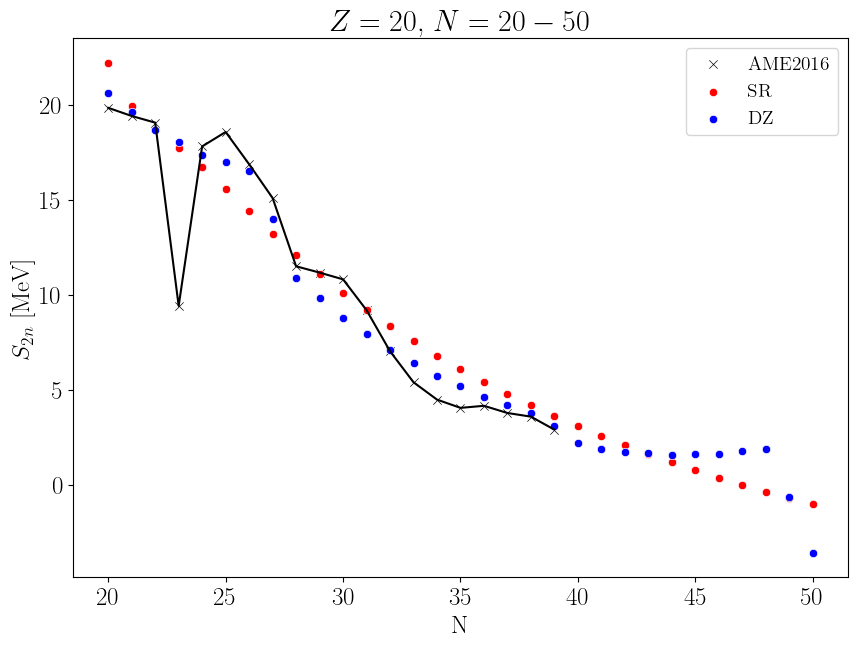

In [43]:
plot_s2n(20, 20, 50)